In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 16000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    # Max Pooling (down-sampling)
    conv5 = maxpool2d(conv5, k=2)
    print(conv3.shape)
    print(conv4.shape)
    print(conv5.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv5, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)

    # Output, class prediction
    fc2 = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    print(fc2.shape)
    return fc2

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 32 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 32])),
    # 3x4 conv, 64 inputs, 32 outputs
    'wc3': tf.Variable(tf.random_normal([3, 4, 32, 32])),
    # 3x4 conv, 64 inputs, 32 outputs
    'wc4': tf.Variable(tf.random_normal([3, 4, 32, 32])),
    # 3x4 conv, 32 inputs, 32 outputs
    'wc5': tf.Variable(tf.random_normal([3, 4, 32, 32])),
    # fully connected, 2*2*32 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*32, 1024])),
    # 1024 inputs, 14 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([32])),
    'bc3': tf.Variable(tf.random_normal([32])),
    'bc4': tf.Variable(tf.random_normal([32])),
    'bc5': tf.Variable(tf.random_normal([32])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 32)
(?, 3, 4, 32)
(?, 3, 4, 32)
(?, 2, 2, 32)
(?, 1024)
(?, 14)


# train and test

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 10429198.000000, Accuracy = 0.0180000010878
Performance on test set: Training epochs #1000, Batch Loss = 5183488.0, Accuracy = 0.0010000000475
Training epochs #20000: Batch Loss = 7307458.000000, Accuracy = 0.0509999990463
Performance on test set: Training epochs #20000, Batch Loss = 2782043.75, Accuracy = 0.0
Training epochs #40000: Batch Loss = 3226633.000000, Accuracy = 0.219999998808
Performance on test set: Training epochs #40000, Batch Loss = 1286902.625, Accuracy = 0.805000007153
Training epochs #60000: Batch Loss = 2281491.500000, Accuracy = 0.487999975681
Performance on test set: Training epochs #60000, Batch Loss = 1384097.0, Accuracy = 0.805000007153
Training epochs #80000: Batch Loss = 1636577.500000, Accuracy = 0.643999934196
Performance on test set: Training epochs #80000, Batch Loss = 1372588.75, Accuracy = 0.805000066757
Training epochs #100000: Batch Loss = 5739106.000000, Accuracy = 0.0549999959767
Performance on test set: Training 

Training epochs #920000: Batch Loss = 251487.671875, Accuracy = 0.723999977112
Performance on test set: Training epochs #920000, Batch Loss = 47157.4648438, Accuracy = 0.955000042915
Training epochs #940000: Batch Loss = 165816.437500, Accuracy = 0.814999997616
Performance on test set: Training epochs #940000, Batch Loss = 63423.1015625, Accuracy = 0.943000018597
Training epochs #960000: Batch Loss = 129147.953125, Accuracy = 0.849999964237
Performance on test set: Training epochs #960000, Batch Loss = 73473.8828125, Accuracy = 0.943000018597
Training epochs #980000: Batch Loss = 1231057.125000, Accuracy = 0.231000006199
Performance on test set: Training epochs #980000, Batch Loss = 44762.4570312, Accuracy = 0.954999983311
Training epochs #1000000: Batch Loss = 182569.937500, Accuracy = 0.756000041962
Performance on test set: Training epochs #1000000, Batch Loss = 43065.6328125, Accuracy = 0.954999983311
Training epochs #1020000: Batch Loss = 166430.843750, Accuracy = 0.81400001049
Per

Training epochs #1820000: Batch Loss = 74496.515625, Accuracy = 0.874000012875
Performance on test set: Training epochs #1820000, Batch Loss = 27222.0878906, Accuracy = 0.961000025272
Training epochs #1840000: Batch Loss = 58158.632812, Accuracy = 0.909999966621
Performance on test set: Training epochs #1840000, Batch Loss = 30079.2519531, Accuracy = 0.955000042915
Training epochs #1860000: Batch Loss = 584519.875000, Accuracy = 0.35900002718
Performance on test set: Training epochs #1860000, Batch Loss = 20901.0449219, Accuracy = 0.961000025272
Training epochs #1880000: Batch Loss = 73671.851562, Accuracy = 0.851000010967
Performance on test set: Training epochs #1880000, Batch Loss = 21314.0039062, Accuracy = 0.961000025272
Training epochs #1900000: Batch Loss = 76560.171875, Accuracy = 0.873000025749
Performance on test set: Training epochs #1900000, Batch Loss = 26211.1679688, Accuracy = 0.961000025272
Training epochs #1920000: Batch Loss = 45073.027344, Accuracy = 0.911999940872
P

Training epochs #2720000: Batch Loss = 29837.988281, Accuracy = 0.941000103951
Performance on test set: Training epochs #2720000, Batch Loss = 16027.9951172, Accuracy = 0.961000025272
Training epochs #2740000: Batch Loss = 306298.656250, Accuracy = 0.481000006199
Performance on test set: Training epochs #2740000, Batch Loss = 9374.41894531, Accuracy = 0.975000083447
Training epochs #2760000: Batch Loss = 40717.781250, Accuracy = 0.888000011444
Performance on test set: Training epochs #2760000, Batch Loss = 9586.44921875, Accuracy = 0.961000025272
Training epochs #2780000: Batch Loss = 40858.042969, Accuracy = 0.909000098705
Performance on test set: Training epochs #2780000, Batch Loss = 13782.5253906, Accuracy = 0.961000025272
Training epochs #2800000: Batch Loss = 25518.632812, Accuracy = 0.941000044346
Performance on test set: Training epochs #2800000, Batch Loss = 15068.2333984, Accuracy = 0.961000025272
Training epochs #2820000: Batch Loss = 299398.875000, Accuracy = 0.477999985218

Training epochs #3620000: Batch Loss = 187729.437500, Accuracy = 0.592000007629
Performance on test set: Training epochs #3620000, Batch Loss = 5553.13183594, Accuracy = 0.982000112534
Training epochs #3640000: Batch Loss = 25213.865234, Accuracy = 0.910000026226
Performance on test set: Training epochs #3640000, Batch Loss = 4832.62451172, Accuracy = 0.981999993324
Training epochs #3660000: Batch Loss = 19599.242188, Accuracy = 0.941000103951
Performance on test set: Training epochs #3660000, Batch Loss = 5404.77392578, Accuracy = 0.975000023842
Training epochs #3680000: Batch Loss = 9628.081055, Accuracy = 0.958000063896
Performance on test set: Training epochs #3680000, Batch Loss = 6253.05761719, Accuracy = 0.975000023842
Training epochs #3700000: Batch Loss = 185186.078125, Accuracy = 0.596999943256
Performance on test set: Training epochs #3700000, Batch Loss = 5170.23291016, Accuracy = 0.981999993324
Training epochs #3720000: Batch Loss = 24039.082031, Accuracy = 0.918000042439


Training epochs #4520000: Batch Loss = 12714.493164, Accuracy = 0.944000065327
Performance on test set: Training epochs #4520000, Batch Loss = 2789.11083984, Accuracy = 0.990000128746
Training epochs #4540000: Batch Loss = 11462.935547, Accuracy = 0.952000021935
Performance on test set: Training epochs #4540000, Batch Loss = 2706.17041016, Accuracy = 0.982000052929
Training epochs #4560000: Batch Loss = 6574.240234, Accuracy = 0.972000062466
Performance on test set: Training epochs #4560000, Batch Loss = 2984.54199219, Accuracy = 0.982000052929
Training epochs #4580000: Batch Loss = 106122.921875, Accuracy = 0.670000016689
Performance on test set: Training epochs #4580000, Batch Loss = 3195.17871094, Accuracy = 0.991000056267
Training epochs #4600000: Batch Loss = 11641.786133, Accuracy = 0.95300000906
Performance on test set: Training epochs #4600000, Batch Loss = 2719.55273438, Accuracy = 0.991000056267
Training epochs #4620000: Batch Loss = 10283.217773, Accuracy = 0.965000033379
Pe

Training epochs #5420000: Batch Loss = 4669.981934, Accuracy = 0.973000049591
Performance on test set: Training epochs #5420000, Batch Loss = 1074.01013184, Accuracy = 0.990000009537
Training epochs #5440000: Batch Loss = 3453.543457, Accuracy = 0.976000010967
Performance on test set: Training epochs #5440000, Batch Loss = 1030.70153809, Accuracy = 0.990000128746
Training epochs #5460000: Batch Loss = 61498.207031, Accuracy = 0.746000051498
Performance on test set: Training epochs #5460000, Batch Loss = 2139.74243164, Accuracy = 0.991000056267
Training epochs #5480000: Batch Loss = 7478.810547, Accuracy = 0.959000110626
Performance on test set: Training epochs #5480000, Batch Loss = 1601.93469238, Accuracy = 0.990999996662
Training epochs #5500000: Batch Loss = 5209.336914, Accuracy = 0.964000046253
Performance on test set: Training epochs #5500000, Batch Loss = 1116.48388672, Accuracy = 0.990000069141
Training epochs #5520000: Batch Loss = 4196.100098, Accuracy = 0.980000019073
Perfor

Training epochs #6320000: Batch Loss = 1107.121216, Accuracy = 0.991999983788
Performance on test set: Training epochs #6320000, Batch Loss = 315.39074707, Accuracy = 0.991000056267
Training epochs #6340000: Batch Loss = 47975.390625, Accuracy = 0.792999923229
Performance on test set: Training epochs #6340000, Batch Loss = 1566.35498047, Accuracy = 0.991000115871
Training epochs #6360000: Batch Loss = 4436.928711, Accuracy = 0.971000015736
Performance on test set: Training epochs #6360000, Batch Loss = 948.07611084, Accuracy = 0.991000056267
Training epochs #6380000: Batch Loss = 3163.094238, Accuracy = 0.981000006199
Performance on test set: Training epochs #6380000, Batch Loss = 396.892730713, Accuracy = 0.991000056267
Training epochs #6400000: Batch Loss = 1205.354736, Accuracy = 0.986999988556
Performance on test set: Training epochs #6400000, Batch Loss = 294.799346924, Accuracy = 0.991000056267
Training epochs #6420000: Batch Loss = 37626.230469, Accuracy = 0.794999957085
Perform

Training epochs #7220000: Batch Loss = 23701.539062, Accuracy = 0.847000002861
Performance on test set: Training epochs #7220000, Batch Loss = 813.80279541, Accuracy = 0.991000056267
Training epochs #7240000: Batch Loss = 1595.867432, Accuracy = 0.983999967575
Performance on test set: Training epochs #7240000, Batch Loss = 347.453643799, Accuracy = 0.994000077248
Training epochs #7260000: Batch Loss = 3420.333008, Accuracy = 0.980000019073
Performance on test set: Training epochs #7260000, Batch Loss = 26.7459373474, Accuracy = 0.994000077248
Training epochs #7280000: Batch Loss = 607.737061, Accuracy = 0.993999958038
Performance on test set: Training epochs #7280000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #7300000: Batch Loss = 24177.152344, Accuracy = 0.850000023842
Performance on test set: Training epochs #7300000, Batch Loss = 721.983947754, Accuracy = 0.991000056267
Training epochs #7320000: Batch Loss = 1926.065796, Accuracy = 0.983000099659
Performance on test set: Tra

Training epochs #8160000: Batch Loss = 744.218689, Accuracy = 0.993000030518
Performance on test set: Training epochs #8160000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #8180000: Batch Loss = 11952.869141, Accuracy = 0.884000003338
Performance on test set: Training epochs #8180000, Batch Loss = 199.852783203, Accuracy = 0.991000056267
Training epochs #8200000: Batch Loss = 1089.246338, Accuracy = 0.983000040054
Performance on test set: Training epochs #8200000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8220000: Batch Loss = 989.072876, Accuracy = 0.991999983788
Performance on test set: Training epochs #8220000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8240000: Batch Loss = 399.461273, Accuracy = 0.994000077248
Performance on test set: Training epochs #8240000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8260000: Batch Loss = 14815.206055, Accuracy = 0.870000004768
Performance on test set: Training epochs #8260000, Batch Loss 

Training epochs #9120000: Batch Loss = 197.836639, Accuracy = 0.998000144958
Performance on test set: Training epochs #9120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9140000: Batch Loss = 7499.625977, Accuracy = 0.914000034332
Performance on test set: Training epochs #9140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9160000: Batch Loss = 363.870148, Accuracy = 0.989999949932
Performance on test set: Training epochs #9160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9180000: Batch Loss = 985.485413, Accuracy = 0.988000035286
Performance on test set: Training epochs #9180000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9200000: Batch Loss = 243.153595, Accuracy = 0.995999932289
Performance on test set: Training epochs #9200000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9220000: Batch Loss = 8705.392578, Accuracy = 0.916000008583
Performance on test set: Training epochs #9220000, Batch Loss = 0.

Training epochs #10080000: Batch Loss = 202.848602, Accuracy = 0.996000051498
Performance on test set: Training epochs #10080000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10100000: Batch Loss = 5120.100098, Accuracy = 0.918000042439
Performance on test set: Training epochs #10100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10120000: Batch Loss = 671.670105, Accuracy = 0.986000061035
Performance on test set: Training epochs #10120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10140000: Batch Loss = 980.788391, Accuracy = 0.991000056267
Performance on test set: Training epochs #10140000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #10160000: Batch Loss = 46.004562, Accuracy = 0.997000098228
Performance on test set: Training epochs #10160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10180000: Batch Loss = 4666.597656, Accuracy = 0.941000044346
Performance on test set: Training epochs #10180000, Batch Loss = 0

Training epochs #11040000: Batch Loss = 75.455078, Accuracy = 0.999000072479
Performance on test set: Training epochs #11040000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #11060000: Batch Loss = 3010.838623, Accuracy = 0.946000039577
Performance on test set: Training epochs #11060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11080000: Batch Loss = 256.533722, Accuracy = 0.996000051498
Performance on test set: Training epochs #11080000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #11100000: Batch Loss = 238.454117, Accuracy = 0.995000004768
Performance on test set: Training epochs #11100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11120000: Batch Loss = 125.764526, Accuracy = 0.995000123978
Performance on test set: Training epochs #11120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11140000: Batch Loss = 2627.606445, Accuracy = 0.952000021935
Performance on test set: Training epochs #11140000, Batch Loss = 0.0, Accura

Training epochs #12000000: Batch Loss = 41.054283, Accuracy = 0.999000072479
Performance on test set: Training epochs #12000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12020000: Batch Loss = 1078.007568, Accuracy = 0.974000036716
Performance on test set: Training epochs #12020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12040000: Batch Loss = 135.636520, Accuracy = 0.995000064373
Performance on test set: Training epochs #12040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12060000: Batch Loss = 208.075058, Accuracy = 0.995000064373
Performance on test set: Training epochs #12060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12080000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #12080000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12100000: Batch Loss = 1297.514771, Accuracy = 0.966000020504
Performance on test set: Training epochs #12100000, Batch L

Training epochs #12960000: Batch Loss = 21.836346, Accuracy = 0.999000072479
Performance on test set: Training epochs #12960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12980000: Batch Loss = 563.920776, Accuracy = 0.978000044823
Performance on test set: Training epochs #12980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13000000: Batch Loss = 10.380188, Accuracy = 0.999000072479
Performance on test set: Training epochs #13000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13020000: Batch Loss = 41.663582, Accuracy = 0.996000051498
Performance on test set: Training epochs #13020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13040000: Batch Loss = 64.189301, Accuracy = 0.999000072479
Performance on test set: Training epochs #13040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13060000: Batch Loss = 587.081055, Accuracy = 0.981000006199
Performance on test set: Training epochs #13060000, Batch Los

Training epochs #13940000: Batch Loss = 703.847839, Accuracy = 0.976000010967
Performance on test set: Training epochs #13940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13960000: Batch Loss = 21.514009, Accuracy = 0.998000085354
Performance on test set: Training epochs #13960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13980000: Batch Loss = 65.668350, Accuracy = 0.996000111103
Performance on test set: Training epochs #13980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14000000: Batch Loss = 8.987055, Accuracy = 0.999000072479
Performance on test set: Training epochs #14000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14020000: Batch Loss = 986.147339, Accuracy = 0.979000031948
Performance on test set: Training epochs #14020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14040000: Batch Loss = 139.670776, Accuracy = 0.995000004768
Performance on test set: Training epochs #14040000, Batch Los

Training epochs #14920000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #14920000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14940000: Batch Loss = 3.830922, Accuracy = 0.998000025749
Performance on test set: Training epochs #14940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14960000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #14960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14980000: Batch Loss = 258.135681, Accuracy = 0.987999975681
Performance on test set: Training epochs #14980000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #15000000: Batch Loss = 4.624500, Accuracy = 0.999000072479
Performance on test set: Training epochs #15000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15020000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #15020000, Batch Loss = 0.0, Accuracy =

Training epochs #15900000: Batch Loss = 2.440203, Accuracy = 0.999000072479
Performance on test set: Training epochs #15900000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15920000: Batch Loss = 2.020164, Accuracy = 0.999000072479
Performance on test set: Training epochs #15920000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #15940000: Batch Loss = 406.994446, Accuracy = 0.98399990797
Performance on test set: Training epochs #15940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15960000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #15960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15980000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #15980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #16000000: Batch Loss = 5.096336, Accuracy = 0.999000072479
Performance on test set: Training epochs #16000000, Batch Loss = 0.0, Accuracy =

# performance visualization

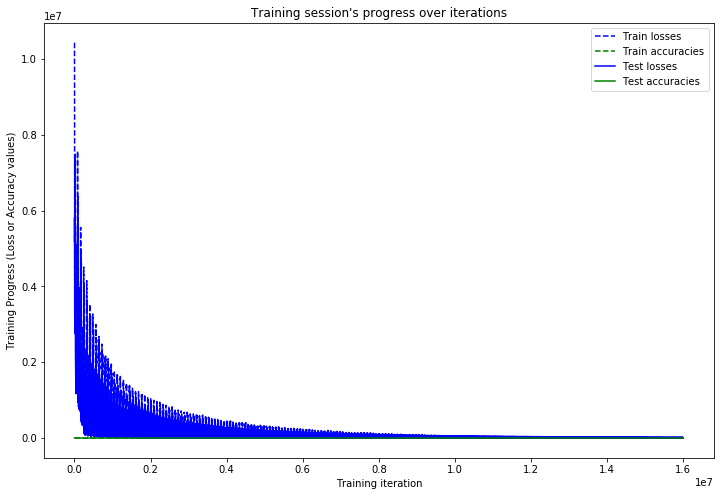

In [9]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 97.8257245197%
Recall: 97.9%
f1_score: 97.8333697662%

Confusion Matrix:
[[    5     3     0     0     0     0     0    10     0     0     0     0
      0]
 [    6   782     0     0    42    30     7    17    11     0     0    16
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     4     0     0  2863     0     0    20     1     0     0     3
      0]
 [    7    17     0     0     0   309     0    12     0     0     0     3
      0]
 [    0     3     0     0     0     4 14486     0     0     0     0     2
      0]
 [    0    44     0     0    37    36     3   402     8     0     0     5
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     0     0     0     0     0     2     0     0     2     0     0
      0]
 [    0     0     0     0     0     0     0    

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


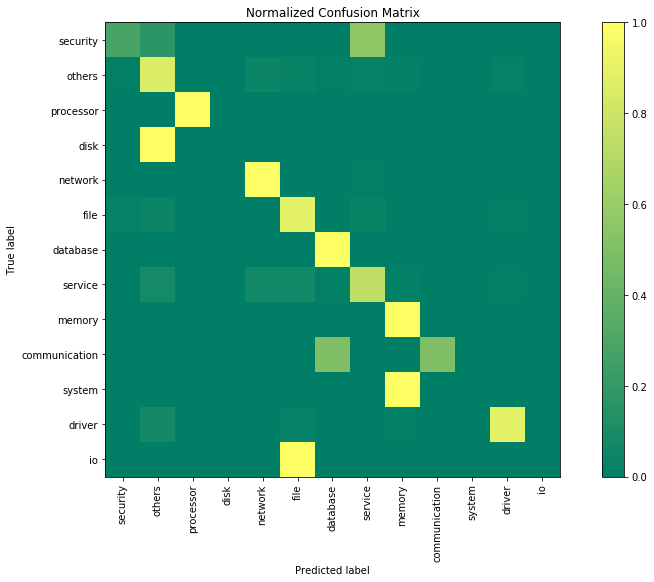

In [10]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)